# 🔎 Detecting Sentiment Shifts in Financial News
This notebook detects temporal sentiment shifts in financial news headlines using FinBERT and changepoint detection.

In [1]:
!pip install transformers datasets torch ruptures seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

## Load Financial News Dataset

In [2]:
import pandas as pd

cnbc_df = pd.read_csv("/content/cnbc_headlines.csv")
guardian_df = pd.read_csv("/content/guardian_headlines.csv")
reuters_df = pd.read_csv("/content/reuters_headlines.csv")



cnbc_df = cnbc_df.dropna(subset=['Headlines', 'Time'])
cnbc_df['date'] = pd.to_datetime(cnbc_df['Time'], errors='coerce')

guardian_df = guardian_df.dropna(subset=['Headlines', 'Time'])
guardian_df['date'] = pd.to_datetime(guardian_df['Time'], errors='coerce')

reuters_df = reuters_df.dropna(subset=['Headlines', 'Time'])
reuters_df['date'] = pd.to_datetime(reuters_df['Time'], errors='coerce')

df = pd.concat([cnbc_df, guardian_df, reuters_df], ignore_index=True)
df['date'] = df['date'].dt.date
df = df.drop(columns=['Time'])

print(df.tail(10))
df.head()


<ipython-input-2-c9c5db55397f>:10: FutureWarning: Parsed string " 7:51  PM ET Fri, 17 July 2020" included an un-recognized timezone "ET". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  cnbc_df['date'] = pd.to_datetime(cnbc_df['Time'], errors='coerce')
<ipython-input-2-c9c5db55397f>:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cnbc_df['date'] = pd.to_datetime(cnbc_df['Time'], errors='coerce')
<ipython-input-2-c9c5db55397f>:10: FutureWarning: Parsed string " 7:33  PM ET Fri, 17 July 2020" included an un-recognized timezone "ET". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized

                                               Headlines  \
53360   BMW searched by German police in emissions swoop   
53361  Exxon eyes Gulf of Mexico plastics plant to me...   
53362  Kenya's ruling party says hired firm linked to...   
53363  White House welcomes looks into reports Trump'...   
53364  EU demands 'unilateral' power over UK banks' a...   
53365  Malaysia says never hired British data firm at...   
53366  Prosecutors search Volkswagen headquarters in ...   
53367   McDonald's sets greenhouse gas reduction targets   
53368  Pratt & Whitney to deliver spare A320neo engin...   
53369  UK will always consider ways to improve data l...   

                                             Description        date  
53360  BMW's headquarters were raided on Tuesday by G...  2018-03-20  
53361  Exxon Mobil Corp  said on Tuesday it was plann...  2018-03-20  
53362  Kenya's ruling Jubilee party said on Tuesday i...  2018-03-20  
53363  President Donald Trump wants Americans' privac..

,Headlines,Description,date
0,Jim Cramer: A better way to invest in the Covi...,"""Mad Money"" host Jim Cramer recommended buying...",2020-07-17
1,Cramer's lightning round: I would own Teradyne,"""Mad Money"" host Jim Cramer rings the lightnin...",2020-07-17
2,"Cramer's week ahead: Big week for earnings, ev...","""We'll pay more for the earnings of the non-Co...",2020-07-17
3,IQ Capital CEO Keith Bliss says tech and healt...,"Keith Bliss, IQ Capital CEO, joins ""Closing Be...",2020-07-17
4,Wall Street delivered the 'kind of pullback I'...,"""Look for the stocks of high-quality companies...",2020-07-16


## Load FinBERT and Predict Sentiments

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')
labels = ['neutral', 'positive', 'negative']

def predict_sentiment(texts):
    sentiments = []
    probs_all = []
    for text in tqdm(texts):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        with torch.no_grad():
            logits = model(**inputs).logits
        probs = torch.softmax(logits, dim=1).squeeze()
        pred = torch.argmax(probs).item()
        sentiments.append(labels[pred])
        probs_all.append(probs.numpy())
    return sentiments, probs_all

df['sentiment'], df['probs'] = predict_sentiment(df['Headlines'].tolist())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

  0%|          | 0/53370 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

  3%|▎         | 1568/53370 [03:47<1:44:40,  8.25it/s]

## Compute Sentiment Scores

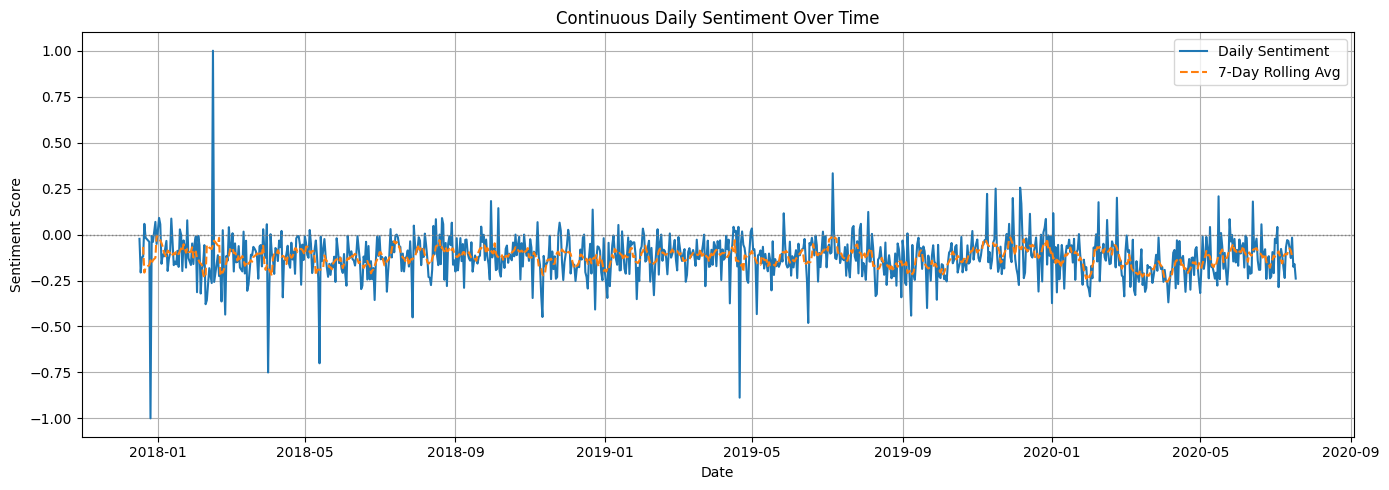

In [ ]:





def compute_sentiment_score(prob):
    return prob[labels.index('positive')] - prob[labels.index('negative')]

df['score'] = df['probs'].apply(compute_sentiment_score)
daily_sentiment = df.groupby('date')['score'].mean().to_frame(name='daily_sentiment')
daily_sentiment['rolling'] = daily_sentiment['daily_sentiment'].rolling(window=7, center=True).mean()

import matplotlib.pyplot as plt

daily_sentiment['daily_sentiment'].plot(figsize=(14, 5), label="Daily Sentiment")
daily_sentiment['rolling'].plot(label="7-Day Rolling Avg", linestyle='--')
plt.axhline(0, color='gray', linestyle=':', linewidth=1)
plt.title("Continuous Daily Sentiment Over Time")
plt.ylabel("Sentiment Score")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## Detect Changepoints using PELT

In [ ]:
import ruptures as rpt

signal = daily_sentiment.values
algo = rpt.Pelt(model='rbf').fit(signal)
result = algo.predict(pen=10)
result

[931]

## Visualize Trends with Changepoints

In [ ]:
!pip install yfinance
import yfinance as yf

[*********************100%***********************]  4 of 4 completed


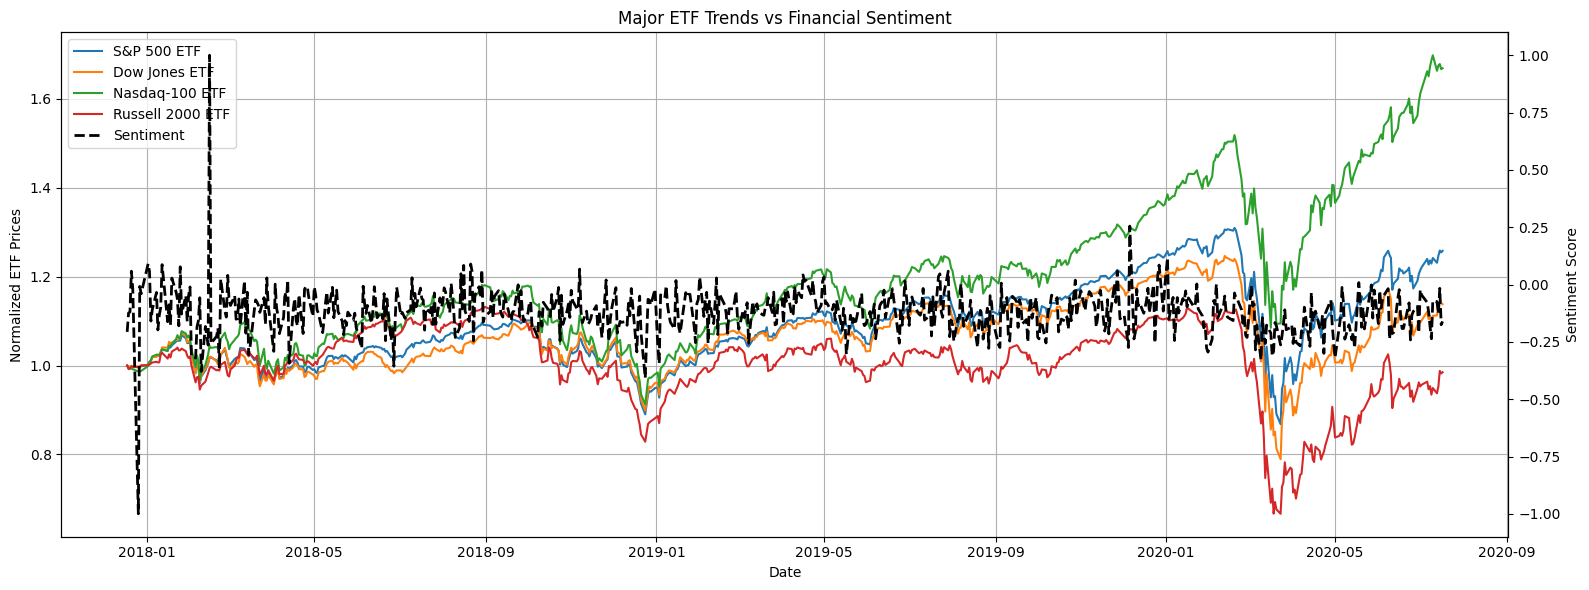

In [ ]:
import yfinance as yf

etfs = {
    'SPY': 'S&P 500 ETF',
    'DIA': 'Dow Jones ETF',
    'QQQ': 'Nasdaq-100 ETF',
    'IWM': 'Russell 2000 ETF'
}

start_date = daily_sentiment.index.min().strftime('%Y-%m-%d')
end_date = daily_sentiment.index.max().strftime('%Y-%m-%d')

etf_data = yf.download(list(etfs.keys()), start=start_date, end=end_date, auto_adjust=True)['Close']

etf_normalized = etf_data / etf_data.iloc[0]

# Convert daily sentiment index to datetime
daily_sentiment.index = pd.to_datetime(daily_sentiment.index)

# Join on index
combined = daily_sentiment.join(etf_normalized, how='inner')




#import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot normalized ETF prices
for ticker in etfs:
    ax1.plot(combined.index, combined[ticker], label=etfs[ticker])

ax1.set_ylabel("Normalized ETF Prices")
ax1.set_xlabel("Date")
ax1.set_title("Major ETF Trends vs Financial Sentiment")
ax1.grid(True)

# Plot sentiment on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(combined.index, combined['daily_sentiment'], color='black', linestyle='--', label='Sentiment', linewidth=2)
ax2.set_ylabel("Sentiment Score")

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()


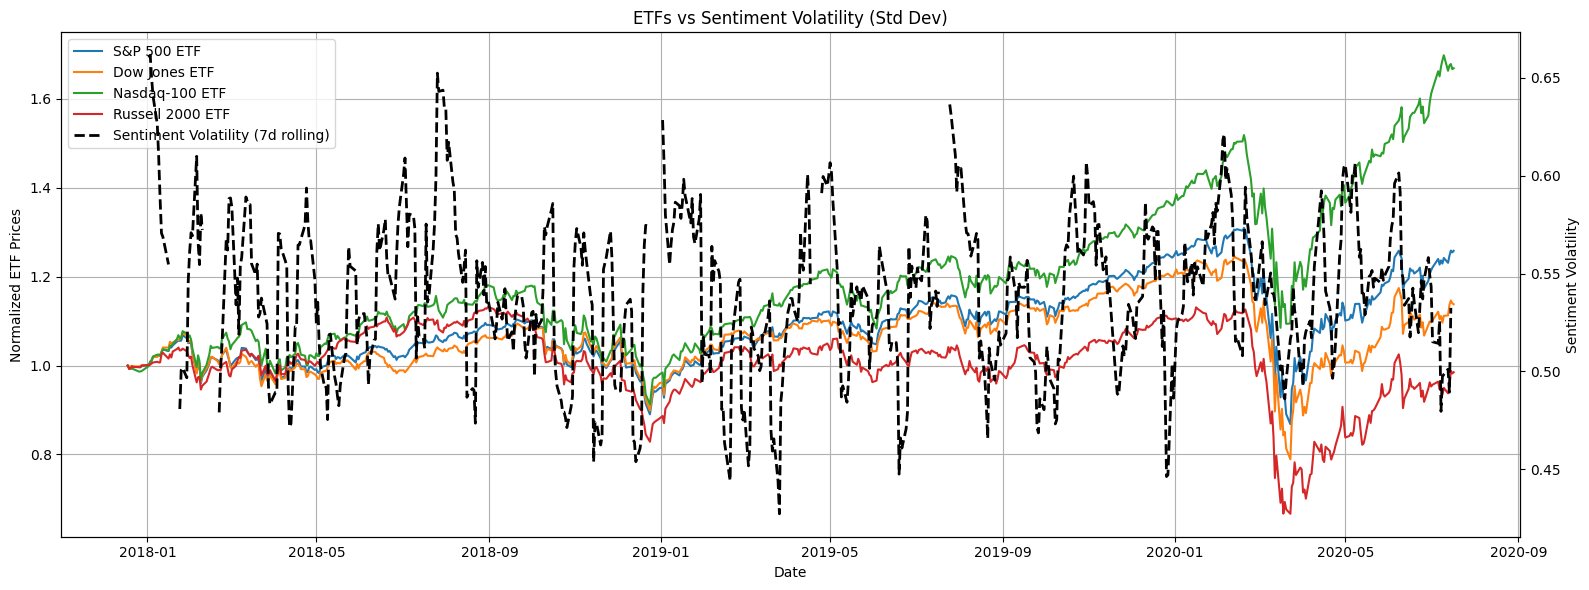

In [ ]:
# Group by day: mean and std of sentiment score
daily_sentiment_stats = df.groupby('date')['score'].agg(['mean', 'std'])
daily_sentiment_stats.columns = ['sentiment_mean', 'sentiment_volatility']

daily_sentiment_stats['sentiment_volatility_rolling'] = daily_sentiment_stats['sentiment_volatility'].rolling(window=7, center=True).mean()
# Join with normalized ETF data
combined_vol = daily_sentiment_stats.join(etf_normalized, how='inner')

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot normalized ETF prices
for ticker in etfs:
    ax1.plot(combined_vol.index, combined_vol[ticker], label=etfs[ticker])

ax1.set_ylabel("Normalized ETF Prices")
ax1.set_xlabel("Date")
ax1.set_title("ETFs vs Sentiment Volatility (Std Dev)")
ax1.grid(True)

# Plot volatility on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(combined_vol.index, combined_vol['sentiment_volatility_rolling'], color='black', linestyle='--', linewidth=2, label='Sentiment Volatility (7d rolling)')
ax2.set_ylabel("Sentiment Volatility")

# Add legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()



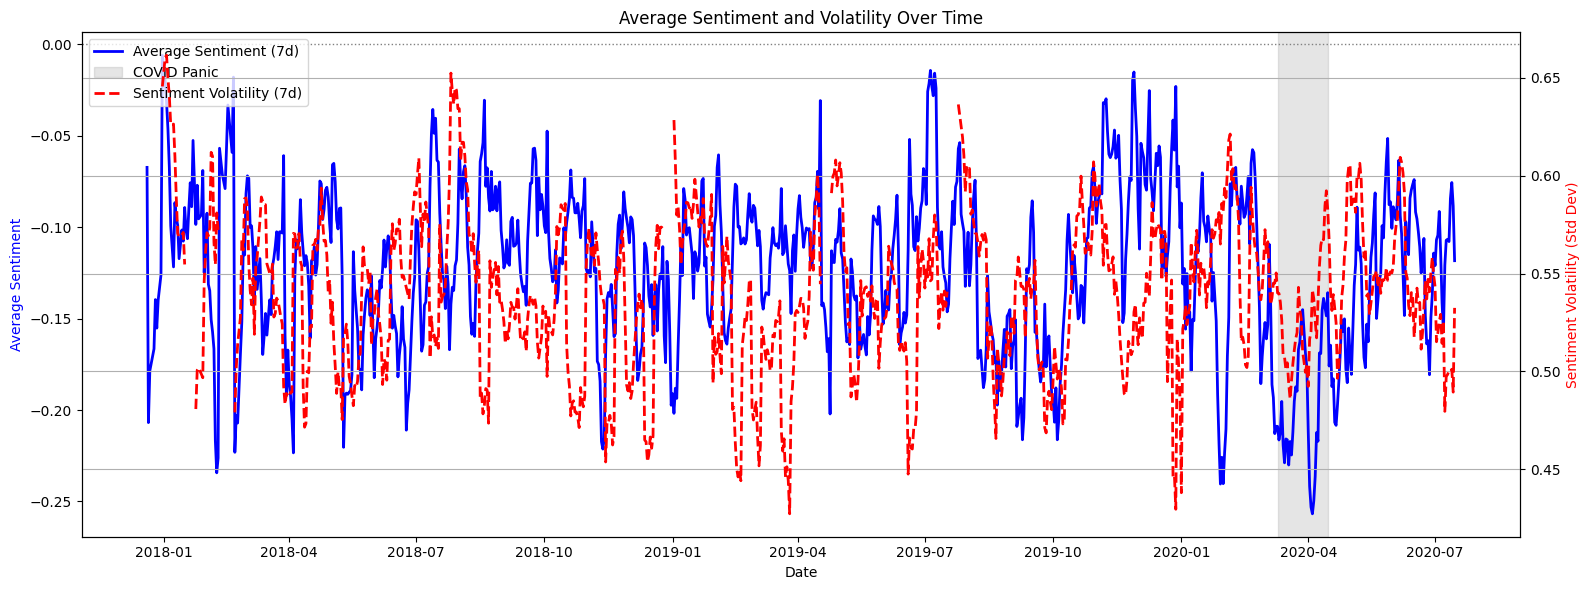

In [ ]:
# Compute daily average and std deviation
daily_sentiment_stats = df.groupby('date')['score'].agg(['mean', 'std'])
daily_sentiment_stats.columns = ['sentiment_mean', 'sentiment_volatility']
daily_sentiment_stats['mean_rolling'] = daily_sentiment_stats['sentiment_mean'].rolling(window=7, center=True).mean()
daily_sentiment_stats['volatility_rolling'] = daily_sentiment_stats['sentiment_volatility'].rolling(window=7, center=True).mean()
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot rolling mean sentiment
ax1.plot(daily_sentiment_stats.index, daily_sentiment_stats['mean_rolling'], color='blue', label='Average Sentiment (7d)', linewidth=2)
ax1.set_ylabel("Average Sentiment", color='blue')
ax1.set_xlabel("Date")

# Add horizontal zero line for neutrality
ax1.axhline(0, color='gray', linestyle=':', linewidth=1)

# Second y-axis for volatility
ax2 = ax1.twinx()
ax2.plot(daily_sentiment_stats.index, daily_sentiment_stats['volatility_rolling'], color='red', label='Sentiment Volatility (7d)', linewidth=2, linestyle='--')
ax2.set_ylabel("Sentiment Volatility (Std Dev)", color='red')

# Add vertical band for COVID crash
ax1.axvspan(pd.to_datetime('2020-03-10'), pd.to_datetime('2020-04-15'), color='gray', alpha=0.2, label='COVID Panic')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title("Average Sentiment and Volatility Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()





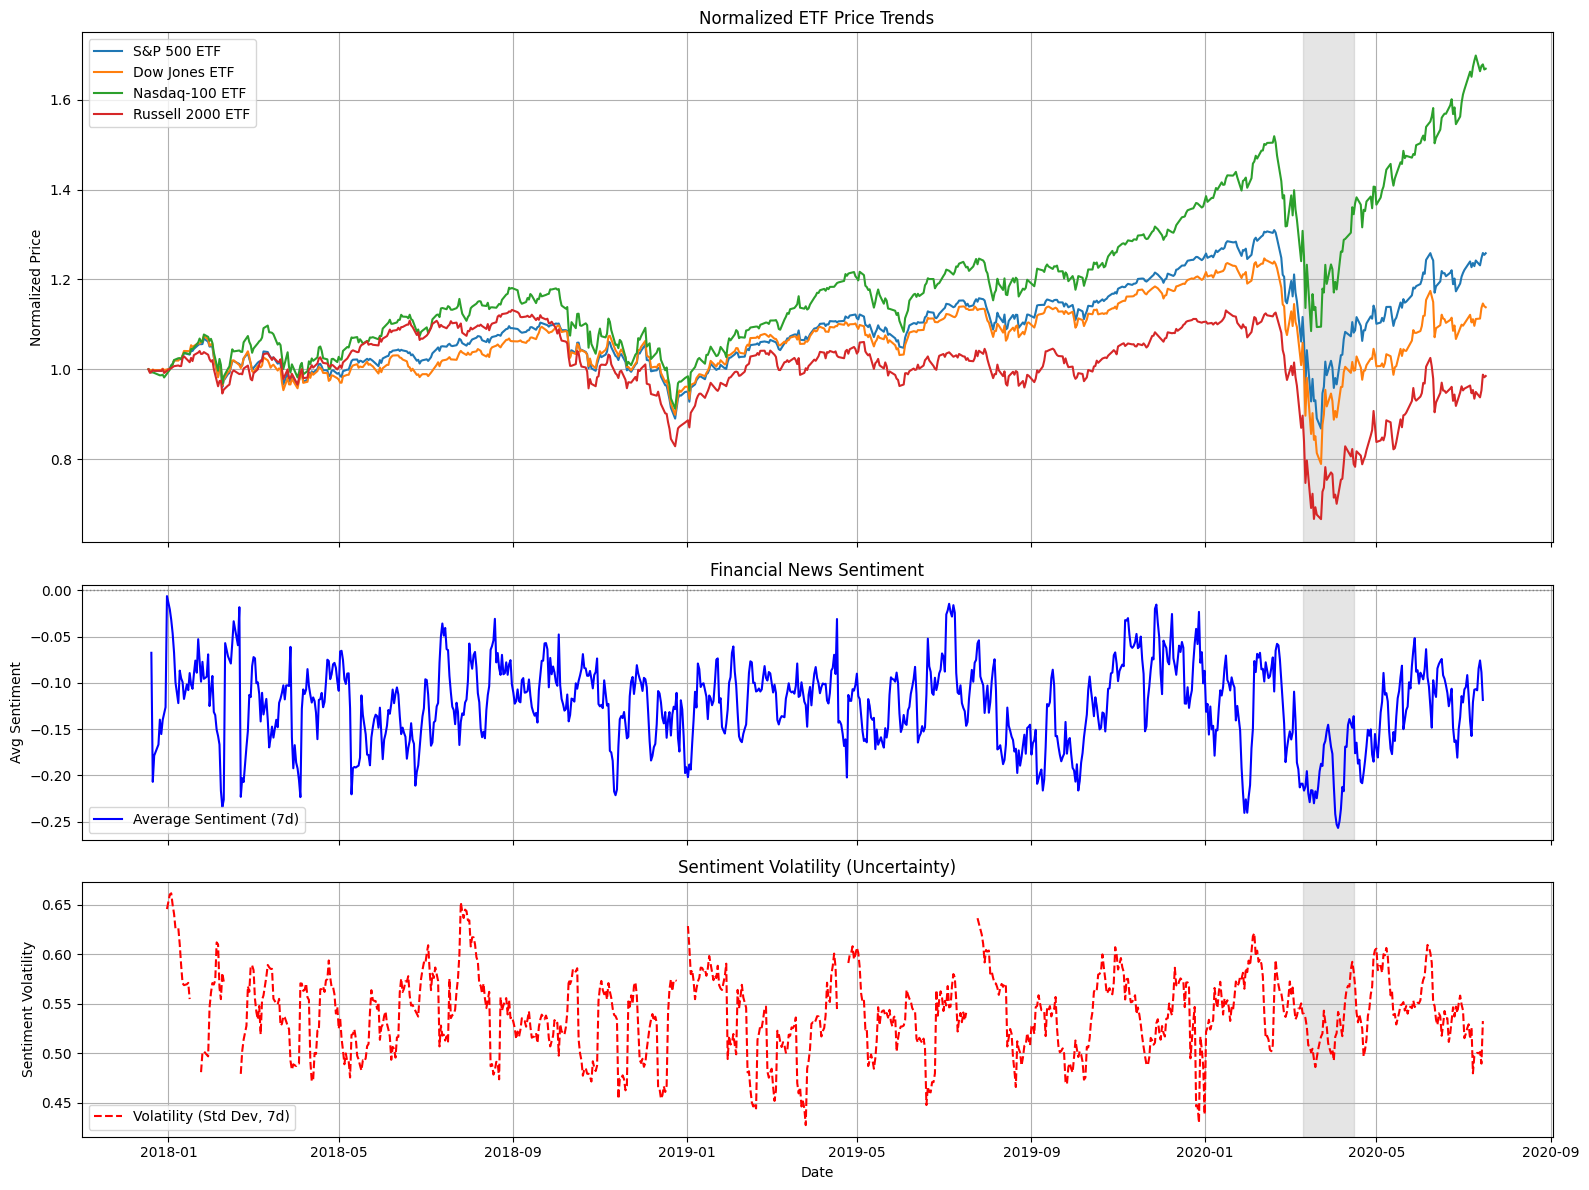

In [ ]:
import matplotlib.pyplot as plt

# Set up the figure with 3 aligned subplots
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(16, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})

# ------------------------------
# ETF Price
# ------------------------------
for ticker in etfs:
    ax0.plot(etf_normalized.index, etf_normalized[ticker], label=etfs[ticker])
ax0.set_title("Normalized ETF Price Trends")
ax0.set_ylabel("Normalized Price")
ax0.legend()
ax0.grid(True)

# ------------------------------
# Sentiment Mean
# ------------------------------
ax1.plot(daily_sentiment_stats.index, daily_sentiment_stats['mean_rolling'], color='blue', label='Average Sentiment (7d)')
ax1.axhline(0, color='gray', linestyle=':', linewidth=1)
ax1.set_ylabel("Avg Sentiment")
ax1.set_title("Financial News Sentiment")
ax1.legend()
ax1.grid(True)

# ------------------------------
#Sentiment Volatility
# ------------------------------
ax2.plot(daily_sentiment_stats.index, daily_sentiment_stats['volatility_rolling'], color='red', linestyle='--', label='Volatility (Std Dev, 7d)')
ax2.set_ylabel("Sentiment Volatility")
ax2.set_title("Sentiment Volatility (Uncertainty)")
ax2.legend()
ax2.grid(True)

# Highlight COVID crash period across all plots
for ax in [ax0, ax1, ax2]:
    ax.axvspan(pd.to_datetime('2020-03-10'), pd.to_datetime('2020-04-15'), color='gray', alpha=0.2)

plt.xlabel("Date")
plt.tight_layout()
plt.show()
